### Create boundary conditions based on observational datasets

For present day experiment. Observations from B-SOSE (http://sose.ucsd.edu/) and WOA. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import glob
import cmocean
import imageio
import pickle
import matplotlib.backends.backend_pdf

#### Functions

In [77]:
def prepare_bdy_transect(month=1, bdy_lat=-50):
    # Arguments:
    # month --- to look at
    # bdy_lat --- latitude of boundary slice
    # Returns: WOA18 and B-SOSE salinity and temperatures at the specified boundary latitude

    # Load datasets:
    SOSE_sal  = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m{month:02}.nc').sel(YC=slice(bdy_lat-1, bdy_lat+1))
    SOSE_temp = xr.open_dataset(f'{folder_SOSE}THETA_climatology_m{month:02}.nc').sel(YC=slice(bdy_lat-1, bdy_lat+1))
    WOA_sal   = xr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', decode_times=False).sel(lat=slice(bdy_lat-1, bdy_lat+1))
    WOA_temp  = xr.open_dataset(f'{folder_WOA}woa18_decav_t{month:02}_04.nc', decode_times=False).sel(lat=slice(bdy_lat-1, bdy_lat+1))

    # Find strip of points nearest bdy_lat and fill any zeros with NaNs:
    SOSE_sal_plt  = xr.where(SOSE_sal.SALT.isel(YC=np.argmin(np.abs(SOSE_sal.YC.values - bdy_lat))) ==0, 
                             np.nan, SOSE_sal.SALT.isel(YC=np.argmin(np.abs(SOSE_sal.YC.values - bdy_lat))))
    SOSE_temp_plt = xr.where(SOSE_temp.THETA.isel(YC=np.argmin(np.abs(SOSE_temp.YC.values - bdy_lat))) ==0, 
                             np.nan, SOSE_temp.THETA.isel(YC=np.argmin(np.abs(SOSE_temp.YC.values - bdy_lat))))
    
    WOA_sal_plt   = WOA_sal.isel(lat=np.argmin(np.abs(WOA_sal.lat.values - bdy_lat)))
    WOA_temp_plt  = WOA_temp.isel(lat=np.argmin(np.abs(WOA_temp.lat.values - bdy_lat)))

    # And for SOSE, convert longitudes from 0-360 to -180 to 180 for pcolormesh
    SOSE_sal_plt['XC']  = xr.where(SOSE_sal_plt.XC  > 180, SOSE_sal_plt.XC  - 360, SOSE_sal_plt.XC)
    SOSE_temp_plt['XC'] = xr.where(SOSE_temp_plt.XC > 180, SOSE_temp_plt.XC - 360, SOSE_temp_plt.XC)
    
    SOSE_sal_plt  = SOSE_sal_plt.sortby('XC')
    SOSE_temp_plt = SOSE_temp_plt.sortby('XC')
    
    return WOA_sal_plt, WOA_temp_plt, SOSE_sal_plt, SOSE_temp_plt

In [101]:
def prepare_bdy_band(lat_band=(-60, -45), month=1, depth=0):
    # Arguments:
    # month --- to look at
    # lat_min, lat_max --- edges of latitude band that you want to look at
    # depth --- depth that you'd like to look at
    # Returns: WOA18 and B-SOSE salinity and temperatures at the specified boundary latitude
    
    # Load datasets:
    WOA_sal   = xr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', decode_times=False).sel(lat=slice(lat_band[0], lat_band[1]))
    WOA_temp  = xr.open_dataset(f'{folder_WOA}woa18_decav_t{month:02}_04.nc', decode_times=False).sel(lat=slice(lat_band[0], lat_band[1]))     
    SOSE_sal  = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m{month:02}.nc').sel(YC=slice(lat_band[0], lat_band[1]))
    SOSE_temp = xr.open_dataset(f'{folder_SOSE}THETA_climatology_m{month:02}.nc').sel(YC=slice(lat_band[0], lat_band[1]))

    # Find index of layer in dataset closest to the specified depth:
    depth_level_WOA  = np.argmin(np.abs(WOA_temp.depth.values - depth))
    depth_level_SOSE = np.argmin(np.abs(SOSE_temp.Z.values - depth))
    WOA_S  = WOA_sal.isel(depth=depth_level_WOA)
    WOA_T  = WOA_temp.isel(depth=depth_level_WOA)
    SOSE_S = SOSE_sal.isel(Z=depth_level_SOSE)
    SOSE_T = SOSE_temp.isel(Z=depth_level_SOSE)
    
    return WOA_S, WOA_T, SOSE_S, SOSE_T

In [132]:
def plot_bdy_transect(month, WOA_S, WOA_T, SOSE_S, SOSE_T, 
                      Trange=(1,10), Srange=(33.4, 34.6), ylim=(1500,0)):
                         
    fig, ax = plt.subplots(4,1, figsize=(18,12))

    fig.suptitle(f'Month: {month:02}', fontsize=12, fontweight='bold')
                          
    kwargs_T = {'vmin':Trange[0], 'vmax':Trange[1], 'cmap':cmocean.cm.thermal, 'rasterized':True}
    kwargs_S = {'vmin':Srange[0], 'vmax':Srange[1], 'cmap':cmocean.cm.haline, 'rasterized':True}
    
    ax[0].set_title('WOA18')
    ax[1].set_title('B-SOSE')
    ax[2].set_title('WOA18')
    ax[3].set_title('B-SOSE')
    
    cm1 = ax[0].pcolormesh(WOA_T.lon, WOA_T.depth, WOA_T.t_an.isel(time=0), **kwargs_T)
    cm2 = ax[1].pcolormesh(SOSE_T.XC, -1*SOSE_T.Z, SOSE_T, **kwargs_T)
    cm3 = ax[2].pcolormesh(WOA_S.lon, WOA_S.depth, WOA_S.s_an.isel(time=0), **kwargs_S)
    cm4 = ax[3].pcolormesh(SOSE_S.XC, -1*SOSE_S.Z, SOSE_S, **kwargs_S)
    
    CB2 = fig.colorbar(cm2, ax=ax[0:2], fraction=0.03, extend='both', label='Temperature (degC)')
    CB4 = fig.colorbar(cm4, ax=ax[2:], fraction=0.03, extend='both', label='Salinity (g/kg)')
    
    for axis in ax.ravel():
        axis.set_ylabel('Depth (m)')
        axis.invert_yaxis()
        axis.set_ylim(ylim[0],ylim[1])
    ax[3].set_xlabel('Longitude')

    return fig

In [147]:
def plot_boundary_band(month, depth, WOA_S, WOA_T, SOSE_S, SOSE_T, 
                       Trange=(0,12), Srange=(32, 34.5), lat_band=(-60, -45)):
                          
    fig, ax = plt.subplots(4,1, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-53)})

    fig.suptitle(f'Month: {month:02}, depth: {depth:.1f}m', fontsize=12, fontweight='bold')
                           
    land_mask = np.ma.masked_where(SOSE_T.THETA.values != 0, SOSE_T.THETA)
        
    for axis in ax.ravel():
        axis.set_extent([-180, 180, lat_band[0], lat_band[1]], ccrs.PlateCarree())
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
        axis.plot([-180, 180], [-50, -50], '--w', transform=ccrs.PlateCarree(), linewidth=3.0)
        axis.pcolormesh(SOSE_T.XC, SOSE_T.YC, land_mask, transform=ccrs.PlateCarree(), 
                        cmap=cmocean.cm.gray_r, rasterized=True, zorder=4)
    
    kwargs_T = {'transform':ccrs.PlateCarree(), 'vmin':Trange[0], 'vmax':Trange[1], 'cmap':cmocean.cm.thermal, 'rasterized':True}
    kwargs_S = {'transform':ccrs.PlateCarree(), 'vmin':Srange[0], 'vmax':Srange[1], 'cmap':cmocean.cm.haline, 'rasterized':True}
    
    ax[0].set_title('WOA18')
    ax[1].set_title('B-SOSE')
    ax[2].set_title('WOA18')
    ax[3].set_title('B-SOSE')
    
    cm1 = ax[0].pcolormesh(WOA_T.lon, WOA_T.lat, WOA_T.t_an.isel(time=0), **kwargs_T)
    cm2 = ax[1].pcolormesh(SOSE_T.XC, SOSE_T.YC, SOSE_T.THETA, **kwargs_T)
    cm3 = ax[2].pcolormesh(WOA_S.lon, WOA_S.lat, WOA_S.s_an.isel(time=0), **kwargs_S)
    cm4 = ax[3].pcolormesh(SOSE_S.XC, SOSE_S.YC, SOSE_S.SALT, **kwargs_S)
    
    CB2 = fig.colorbar(cm2, ax=ax[0:2], fraction=0.03, extend='both', label='Temperature (degC)')
    CB4 = fig.colorbar(cm4, ax=ax[2:], fraction=0.03, extend='both', label='Salinity (g/kg)')

    return fig

#### Definitions

In [111]:
# File locations
folder_WOA  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/'
folder_SOSE = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/'
folder_terra= '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/'

### Transect along boundary

In [ ]:
fig1 = {}
for month in range(1,13):
    WOA_S, WOA_T, SOSE_S, SOSE_T = prepare_bdy_transect(month=month, bdy_lat=-50)
    fig1[f'm{month:02}']         = plot_bdy_transect(month, WOA_S, WOA_T, SOSE_S, SOSE_T, 
                                                     Trange=(0,10), Srange=(33.4, 35), ylim=(6000,0))

pdf1 = matplotlib.backends.backend_pdf.PdfPages(f"{folder_terra}WOA_SOSE_boundary_transect_fulldepth.pdf")
for month in range(1,13):
    pdf1.savefig(fig1[f'm{month:02}'])
pdf1.close()

### Bands along boundaries

In [ ]:
depth = 500
fig2 = {}
for month in range(1,13):
    WOA_S, WOA_T, SOSE_S, SOSE_T = prepare_bdy_band(lat_band=(-60, -45), month=month, depth=depth)
    fig2[f'm{month:02}'] = plot_boundary_band(month, depth, WOA_S, WOA_T, SOSE_S, SOSE_T, 
                                             Trange=(0,14), Srange=(33, 34.8), lat_band=(-60, -45))

pdf2 = matplotlib.backends.backend_pdf.PdfPages(f"{folder_terra}WOA_SOSE_boundary_band_{depth}m.pdf")
for month in range(1,13):
    pdf2.savefig(fig2[f'm{month:02}'])
pdf2.close()

### TS diagrams

In [157]:
month=1
WOA_S, WOA_T, SOSE_S, SOSE_T = prepare_bdy_transect(month=month, bdy_lat=-50)

In [180]:
WOA_dz, WOA_lons   = np.meshgrid(WOA_S.depth.values, WOA_S.lon.values)
SOSE_dz, SOSE_lons = np.meshgrid(SOSE_S.Z.values, SOSE_S.XC.values)

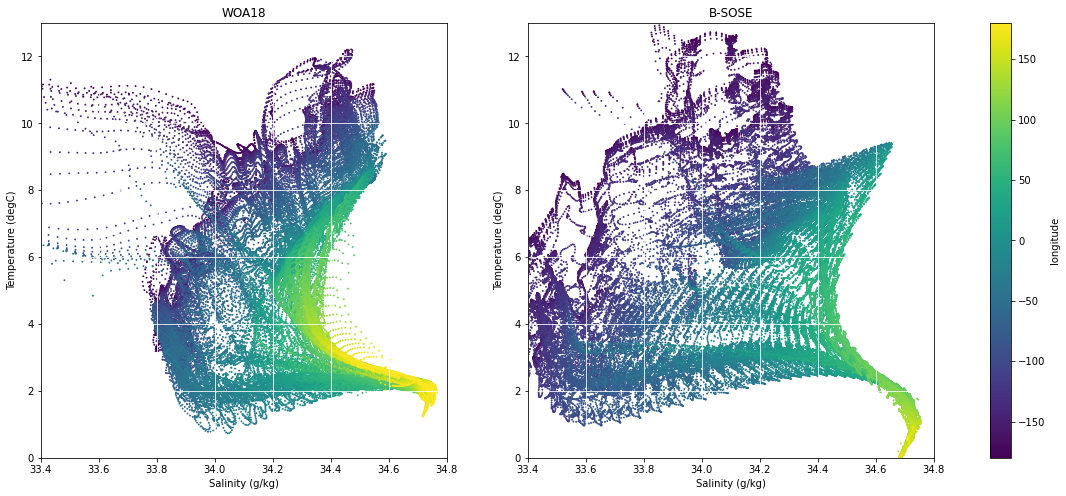

In [193]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].set_title('WOA18')
ax[1].set_title('B-SOSE')

cm = ax[0].scatter(WOA_S.isel(time=0).s_an, WOA_T.isel(time=0).t_an, c=WOA_lons, label='WOA18', s=0.8)
cm = ax[1].scatter(SOSE_S, SOSE_T, c=SOSE_lons, label='B-SOSE', s=0.8)

for axis in ax.ravel():
    axis.set_xlabel('Salinity (g/kg)')
    axis.set_ylabel('Temperature (degC)')
    axis.set_xlim(33.4, 34.8)
    axis.set_ylim(0, 13)
    axis.grid(c='white')

cb = fig.colorbar(cm, ax=ax, label='longitude')

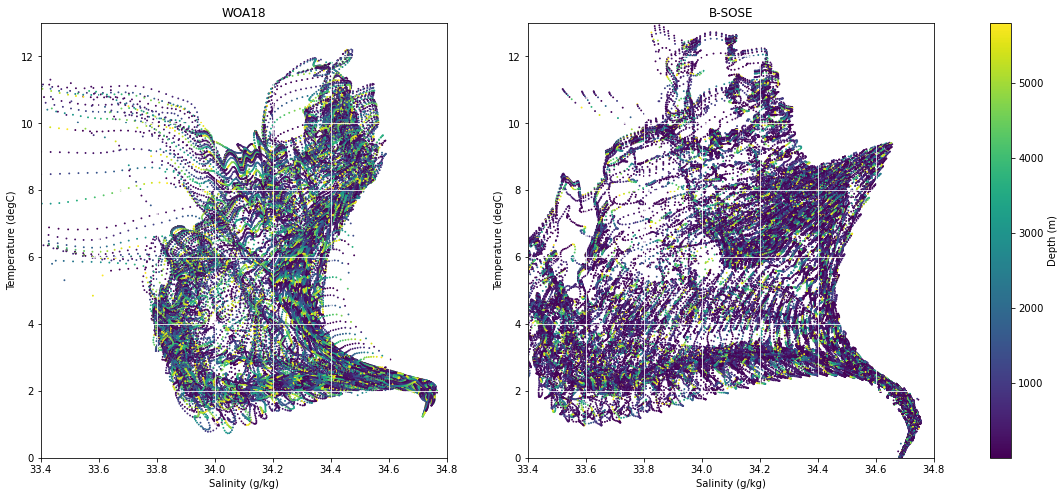

In [191]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].set_title('WOA18')
ax[1].set_title('B-SOSE')

cm = ax[0].scatter(WOA_S.isel(time=0).s_an, WOA_T.isel(time=0).t_an, c=WOA_dz, label='WOA18', s=0.8)
cm = ax[1].scatter(SOSE_S, SOSE_T, c=-1*SOSE_dz, label='B-SOSE', s=0.8)

for axis in ax.ravel():
    axis.set_xlabel('Salinity (g/kg)')
    axis.set_ylabel('Temperature (degC)')
    axis.set_xlim(33.4, 34.8)
    axis.set_ylim(0, 13)
    axis.grid(c='white')

cb = fig.colorbar(cm, ax=ax, label='Depth (m)')

### Other stuff: 

In [6]:
def plot_WOA_SOSE(month):

    fig, ax = plt.subplots(2,2, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

    for axis in ax.ravel():
        axis.set_extent([-90, -160, -78, -66], ccrs.PlateCarree())
        cs = axis.contour(SOSE_sal_jan.XC, SOSE_sal_jan.YC, SOSE_sal_jan.Depth, levels=[1000, 2000], 
                          colors='w', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
        gl = axis.gridlines(draw_labels=True);
        gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    
    #----------------------------- WOA18 -----------------------------
    fig.text(1, 1.1, f'WOA18: 1955-2017 climatology, month: {month:02}, depth: {WOA_temp.depth.values} m', 
             fontweight='bold', transform=ax[0,0].transAxes);
    
    cm1 = ax[0,0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0), 
                             transform=ccrs.PlateCarree(), vmin=33.5, vmax=35, rasterized=True)
    CB1 = fig.colorbar(cm1, ax=ax[0,0], fraction=0.03, label='Sea water salinity at standard depths (g/kg)')
    
    cm2 = ax[0,1].pcolormesh(WOA_temp.lon, WOA_temp.lat, WOA_temp.t_an.isel(time=0), 
                           transform=ccrs.PlateCarree(), vmin=-2, vmax=2, rasterized=True)
    CB2 = fig.colorbar(cm2, ax=ax[0,1], fraction=0.03, label='Sea water temperature at standard depths (degC)')
    
    #----------------------------- B-SOSE -----------------------------
    fig.text(1, 1.1, f'B-SOSE: 2013-2021 climatology, month: {month:02}, depth: {-1*SOSE_sal_jan.Z.values:.1f} m', 
             fontweight='bold', transform=ax[1,0].transAxes);
    
    cm3 = ax[1,0].pcolormesh(SOSE_sal_jan.XC, SOSE_sal_jan.YC, SOSE_sal_jan, 
                             transform=ccrs.PlateCarree(), vmin=33.5, vmax=35, rasterized=True)
    CB3 = fig.colorbar(cm3, ax=ax[1,0], fraction=0.03, label='Salinity (g/kg)')
    
    cm4 = ax[1,1].pcolormesh(SOSE_temp_jan.XC, SOSE_temp_jan.YC, SOSE_temp_jan, 
                           transform=ccrs.PlateCarree(), vmin=-2, vmax=2, rasterized=True)
    CB4 = fig.colorbar(cm4, ax=ax[1,1], fraction=0.03, label='Potential temperature (degC)')
    
    land_mask = np.ma.masked_where(SOSE_temp_jan.values != 0, SOSE_temp_jan)
    for axis in ax[1,:].ravel():
        axis.pcolormesh(SOSE_temp_jan.XC, SOSE_temp_jan.YC, land_mask, transform=ccrs.PlateCarree(), 
                        cmap=cmocean.cm.gray_r, rasterized=True)
    
    return fig

In [ ]:
depth_level_WOA  = 23
depth_level_SOSE = 18

fig = {}
for month in range(1,13):
    print('Month: ', month)
    
    WOA_sal  = xr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', 
                               decode_times=False).sel(lat=slice(-78, -65), lon=slice(-160, -90)).isel(depth=depth_level_WOA)
    WOA_temp = xr.open_dataset(f'{folder_WOA}woa18_decav_t{month:02}_04.nc', 
                               decode_times=False).sel(lat=slice(-78, -65), lon=slice(-160, -90)).isel(depth=depth_level_WOA)
        
    SOSE_temp_jan = SOSE_temp.THETA.isel(time=(SOSE_temp.time.dt.month == month), 
                                             Z=depth_level_SOSE).sel(YC=slice(-78,-65), XC=slice(200,270)).mean(dim='time')
    SOSE_sal_jan  = SOSE_sal.SALT.isel(time=(SOSE_sal.time.dt.month == month)   , 
                                           Z=depth_level_SOSE).sel(YC=slice(-78,-65), XC=slice(200,270)).mean(dim='time')
    
    fig[f'm{month:02}'] = plot_WOA_SOSE(month)
        
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{folder_terra}Amundsen-WOA-SOSE_comparison_z{depth_level_WOA:02}.pdf")
for month in range(1,13):
    pdf.savefig(fig[f'm{month:02}'])
pdf.close()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,10))

for month in range(1,13):
    print(month)
    lat_slice  = slice(-78, -65)
    lon_slice  = slice(-160, -90)
    lon2_slice = slice(200, 270)
    
    WOA_sal_mean  = xr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', 
                        decode_times=False).sel(lat=lat_slice, lon=lon_slice).s_an.isel(time=0).mean(dim=('lat', 'lon'))
    
    WOA_temp_mean = xr.open_dataset(f'{folder_WOA}woa18_decav_t{month:02}_04.nc', 
                        decode_times=False).sel(lat=lat_slice, lon=lon_slice).t_an.isel(time=0).mean(dim=('lat', 'lon'))
            
    SOSE_temp_m = SOSE_temp.THETA.isel(time=(SOSE_temp.time.dt.month == month)).sel(YC=lat_slice, XC=lon2_slice).mean(dim='time')
    SOSE_sal_m  = SOSE_sal.SALT.isel(time=(SOSE_sal.time.dt.month == month)).sel(YC=lat_slice, XC=lon2_slice).mean(dim='time')
    SOSE_temp_mean = xr.where(SOSE_temp_m == 0, np.nan, SOSE_temp_m).mean(dim=('YC', 'XC'))
    SOSE_sal_mean  = xr.where(SOSE_sal_m == 0, np.nan, SOSE_sal_m).mean(dim=('YC', 'XC'))

    ax[0].plot(WOA_temp_mean, WOA_temp_mean.depth, label='_nolabel', c='#2574f4')
    ax[0].plot(SOSE_temp_mean, -1*SOSE_temp_mean.Z, label='_nolabel', c='#fbbd3c')

    if month==1:
        ax[1].plot(WOA_sal_mean, WOA_sal_mean.depth, label='WOA18', c='#2574f4')
        ax[1].plot(SOSE_sal_mean, -1*SOSE_sal_mean.Z, label='B-SOSE', c='#fbbd3c')
    else:
        ax[1].plot(WOA_sal_mean, WOA_sal_mean.depth, label='_nolabel', c='#2574f4')
        ax[1].plot(SOSE_sal_mean, -1*SOSE_sal_mean.Z, label='_nolabel', c='#fbbd3c')

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top') 
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.tick_params(axis='both', which='minor', labelsize=12)
    
ax[0].set_ylabel('Depth (m)', fontsize=12)
ax[0].set_xlabel('Temperature (degC)', fontsize=12)
ax[1].set_xlabel('Salinity (g/kg)', fontsize=12)

ax[1].legend(frameon=False, loc=(0.1, 0.6), fontsize=12)

fig.savefig('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/TSz_monthly_climatology_BSOSE_WOA18_Amundsen.jpg')

##### WOA

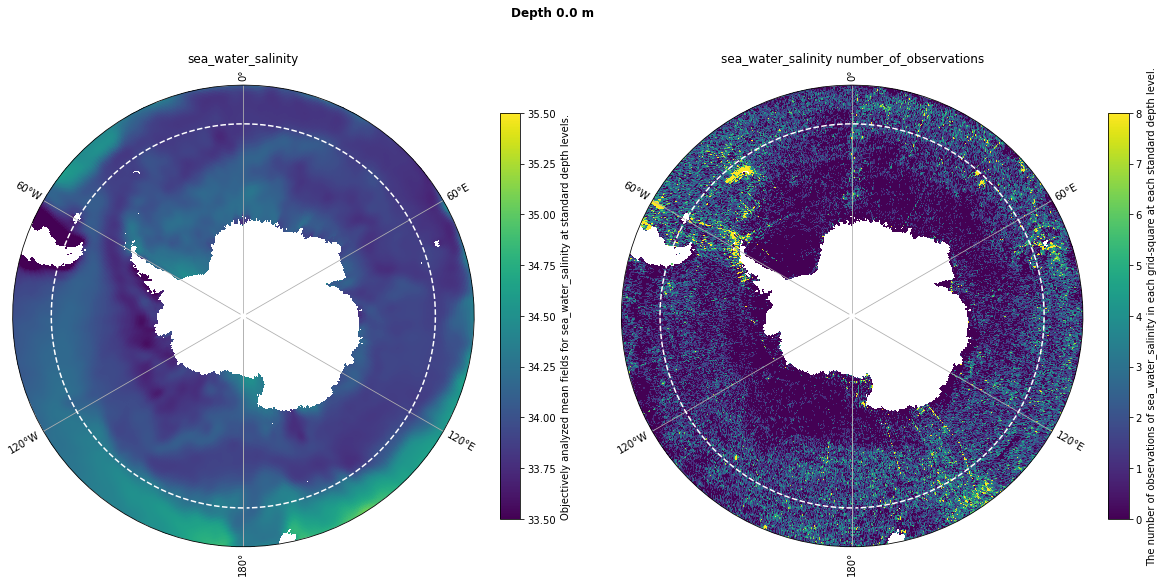

In [34]:
fig, ax = prepare_plot(subs=(1,2), figsize=(20,9))

cm1 = ax[0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0, depth=0), transform=ccrs.PlateCarree(), vmin=33.5, vmax=35.5)
cm2 = ax[1].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_dd.isel(time=0, depth=0), transform=ccrs.PlateCarree(), vmin=0, vmax=8)

ax[0].set_title(WOA_sal.s_an.standard_name)
ax[1].set_title(WOA_sal.s_dd.standard_name)
ax[0].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
ax[1].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);

CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04, label=WOA_sal.s_an.long_name)
CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04, label=WOA_sal.s_dd.long_name)

fig.suptitle(f'Depth {WOA_sal.depth.values[0]} m', fontweightxr.open_dataset(f'{folder_WOA}woa18_decav_s{month:02}_04.nc', 
                        decode_times=False).sel(lat=lat_slice, lon=lon_slice).s_an.isel(time=0)='bold');

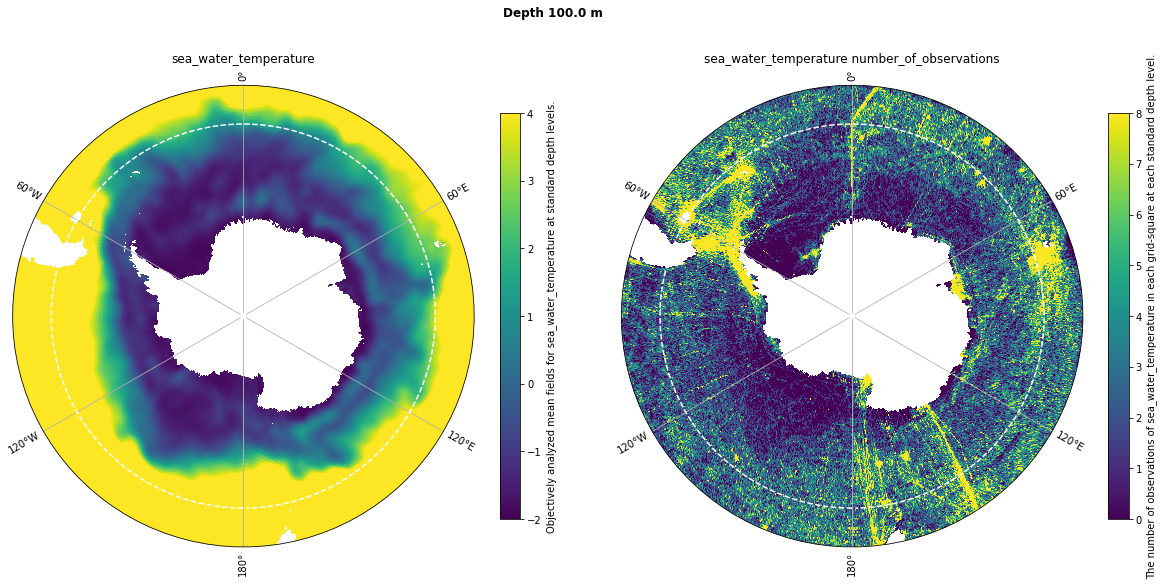

In [38]:
fig, ax = prepare_plot(subs=(1,2), figsize=(20,9))

cm1 = ax[0].pcolormesh(WOA_temp.lon, WOA_temp.lat, WOA_temp.t_an.isel(time=0, depth=20), transform=ccrs.PlateCarree(), vmin=-2, vmax=5)
cm2 = ax[1].pcolormesh(WOA_temp.lon, WOA_temp.lat, WOA_temp.t_dd.isel(time=0, depth=20), transform=ccrs.PlateCarree(), vmin=0, vmax=8)

ax[0].set_title(WOA_temp.t_an.standard_name)
ax[1].set_title(WOA_temp.t_dd.standard_name)
ax[0].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
ax[1].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);

CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04, label=WOA_temp.t_an.long_name)
CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04, label=WOA_temp.t_dd.long_name)

fig.suptitle(f'Depth {WOA_temp.depth.values[20]} m', fontweight='bold');

In [36]:
for depth in range(0, len(WOA_sal.depth)):
    create_animation(WOA_sal, 's_an', 's_dd', depth, vmin=33.5, vmax=35.5,
                     filename=f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/sal_depth_animation/s_an_dd_{depth:03}.jpg')

In [6]:
for depth in range(0, len(WOA_temp.depth)):
    create_animation(WOA_temp, 't_an', 't_dd', depth, vmin=-2, vmax=5, 
                     filename=f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/WOA18/temp_depth_animation/t_an_dd_{depth:03}.jpg')

##### B-SOSE

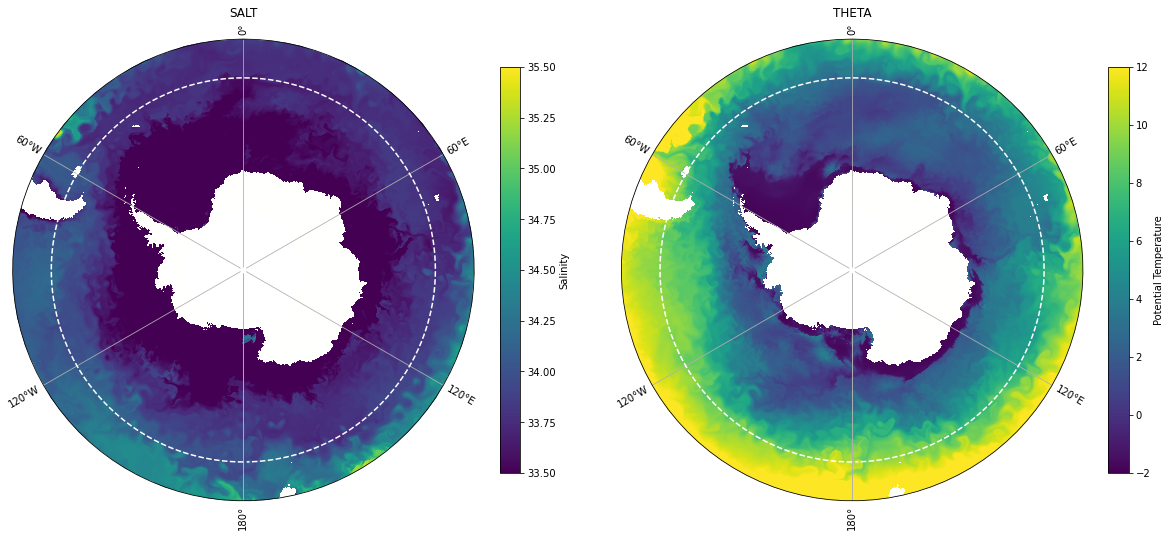

In [7]:
fig, ax = prepare_plot(subs=(1,2), figsize=(20,9))

land_mask = np.ma.masked_where(SOSE_temp.THETA.isel(time=0, Z=0).values != 0, SOSE_temp.THETA.isel(time=0, Z=0))

cm1 = ax[0].pcolormesh(SOSE_sal.XC, SOSE_sal.YC, SOSE_sal.SALT.isel(time=0, Z=0), transform=ccrs.PlateCarree(), vmin=33.5, vmax=35.5)
cm2 = ax[1].pcolormesh(SOSE_temp.XC, SOSE_temp.YC, SOSE_temp.THETA.isel(time=0, Z=0), transform=ccrs.PlateCarree(), vmin=-2, vmax=12)
ax[0].pcolormesh(SOSE_sal.XC, SOSE_sal.YC, land_mask, transform=ccrs.PlateCarree(), cmap=cmocean.cm.gray_r)
ax[1].pcolormesh(SOSE_sal.XC, SOSE_sal.YC, land_mask, transform=ccrs.PlateCarree(), cmap=cmocean.cm.gray_r)

ax[0].set_title(SOSE_sal.SALT.standard_name)
ax[1].set_title(SOSE_temp.THETA.standard_name)
ax[0].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);
ax[1].plot(np.arange(-180,180,1), np.ones(np.arange(-180,180,1).shape)*-52, '--w', transform=ccrs.PlateCarree(), zorder=3);

CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04, label=SOSE_sal.SALT.long_name)
CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04, label=SOSE_temp.THETA.long_name)

# fig.suptitle(f'Depth {WOA_sal.depth.values[0]} m', fontweight='bold');